<a href="https://colab.research.google.com/github/luke-scot/emissions-tracking/blob/main/notebooks/project_overview_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo for supply chain emissions tracking via graph representation learning
Press play or 'Shift+Enter' to run each cell in the notebook. Please contact Luke Cullen at lshc3@cam.ac.uk for any queries.

In [1]:
# @title Initialise notebook
%%capture
%pip install floweaver ipysankeywidget

# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
import seaborn as sns
import itertools
import ipywidgets as ipw
import scipy.stats as stats
from floweaver import *
from ipysankeywidget import SankeyWidget
import gdown, os
from google.colab import files

"""Import example data"""
# Import and unzip files -> You can then view them in the left files panel
folder, zip_path = 'data', 'data.zip'
if not os.path.exists(folder): 
  gdown.download('https://drive.google.com/uc?id=1Mfsng1fdod8Ng_dBMyZ8SwG4oKo-0ZFm', zip_path ,quiet=True)
  ! unzip $zip_path -d 'data'
  ! rm $zip_path

import data.utilities as utl

# Variable definition
# lcaDataPath = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent\EcoInvent_B0729/xml_openLCA"
# inOutPath = "C:/Users\lukec\OneDrive - University of Cambridge\Projects\PhD\Data\EcoInvent\EcoInvent_B0729/xml_EI/"
impactMethods = "data/IPCC2013.xml"
processes_file = "data/GWP100a_IPCC2013.csv"

In [2]:
# @title Initialise Colab outputs
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
# @title Read in impact factors
# @markdown Impact factors define the CO2 equivalent value of process emissions
def read_xml_attributes(filepath:str,branches:list,attributes:list,df=False):
    """This function creates a dataframe of attributes within an xml file.\n
    Inputs:\n
    filepath - path to xml file\n
    branches - list of successive branch choices\n
    attributes - attributes to be read from chosen branch\n
    Outputs:\n
    df - pandas dataframe of attributes for each end branch\n
    Requirements: pandas as pd, xml.etree.ElementTree as ET"""
    if df is False: df = pd.DataFrame([],columns=[i for sublist in utl.to_listlist(attributes) for i in sublist])
    tree_loc = ET.parse(filepath).getroot()
    branches, attributes = utl.to_listlist(branches), utl.to_listlist(attributes)
    attr_values = dict()
    for pathnum, path in enumerate(branches):
        for branch in path:
            for num,val in enumerate([branch in i.tag for i in tree_loc]):
                if val:
                    if branch is path[-1]:
                        attr_values.update(dict(zip(attributes[pathnum],[tree_loc[num].attrib[i] if i else tree_loc[num].text for i in attributes[pathnum]])))
                        if path is branches[-1]: df = df.append(attr_values,ignore_index=True)
                    else:
                        tree_loc=tree_loc[num]
                        break
    return df

# Fetch and display impact factors
impacts = read_xml_attributes(impactMethods,['dataset','flowData','exchange'],['name','category','subCategory','meanValue'])
impacts.sort_values('name')

,name,category,subCategory,meanValue
56,"Carbon dioxide, fossil",Emission to air,unspecified,1.0
45,"Carbon dioxide, fossil",Emission to air,low population density,1.0
164,"Carbon dioxide, fossil",Emission to air,"low population density, long-term",1.0
69,"Carbon dioxide, fossil",Emission to air,lower stratosphere + upper troposphere,1.0
19,"Carbon dioxide, fossil",Emission to air,high population density,1.0
...,...,...,...,...
189,Sulfur hexafluoride,Emission to air,lower stratosphere + upper troposphere,23506.81999316
79,Sulfur hexafluoride,Emission to air,"low population density, long-term",23506.81999316
44,Sulfur hexafluoride,Emission to air,low population density,23506.81999316
3,Sulfur hexafluoride,Emission to air,unspecified,23506.81999316


In [4]:
#@title Load in CO2e values for mining materials
def calculate_co2e(filepath:str, lookup:pd.DataFrame, branches:list=None, attributes:list=None):
    """This function calculates total CO2e impacts for processes given the outputs and impact factors\n
    Inputs:\n
    filepath - path to process xml file\n
    lookup - dataframe with CO2e values for a unit of output materials\n
    branches - branches for outputs in xml file\n
    attributes - attributes at destination branch in xml file\n
    Output: Float of total CO2e due to process.\n
    Requirements: pandas as pd, read_xml_attributes function"""
    # Defaults
    if attributes is None: attributes = ['name', 'category', 'subCategory', 'meanValue']
    if branches is None: branches = ['dataset', 'flowData', 'exchange']
    # Calculation
    product = read_xml_attributes(filepath,branches,attributes)
    product = product.rename(columns={attributes[-1]: "kg"})
    emissions = product.merge(lookup)
    return sum(pd.to_numeric(emissions['kg'])*pd.to_numeric(emissions[attributes[-1]]))

def import_xml_batch(directory:str,path:list,attributes:list,co2e=False,impacts=False):
    """This function imports xml data into a pandas dataframe inputs:\n
    directory - directory of xml files\n
    path - location of attributes within xml\n
    attributes - names of attributes/column names\n
    outputs:\n
    df - dataframe of requested attributes\n
    Requirements: os, pandas as pd, xml.etree.ElementTree as ET"""
    file_list = os.listdir(directory)
    attributes = utl.to_listlist(attributes)
    df = pd.DataFrame([],columns=[j for i in attributes for j in i])
    if co2e is not False: df[co2e] = None
    for file in tqdm(file_list):
        df = read_xml_attributes(os.path.join(directory, file),path,attributes,df)
        if co2e is not False: df[co2e].iloc[-1] = calculate_co2e(os.path.join(directory, file), impacts)
    return df, file_list

#processes, _ = import_xml_batch(lcaDataPath,[['dataset','meta','process','reference'],['dataset','meta','process','geo']],[['name','generalComment'],['location']],'CO2e',impacts)

# Save or load processes file
if 'processes' in locals(): processes.sort_values('name').to_csv(processes_file)
else: processes = pd.read_csv(processes_file,index_col=0)

# Filter dataframe for non market activities
production = processes[~ processes['generalComment'].str.contains('market')].sort_values('name')
production

,name,generalComment,location,CO2e
249,barite,This dataset refers to the production of 1 kg ...,BR,0.020889
241,barite,This dataset has been copied from an original ...,RoW,0.031836
142,bauxite,Average moisture content of bauxite is approxi...,GLO,0.012219
114,bulk lead-zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.418987
224,"calcium carbonate, precipitated",For the separation and refining of rare earth ...,CN-SC,3.496398
...,...,...,...,...
51,zinc concentrate,From metal containing ore extraction from the ...,CA-QC,0.463061
126,zinc concentrate,"The multi-output ""zinc mine operation"" process...",GLO,0.438609
192,"zircon, 50% zirconium",This dataset refers to the production of 1 kg ...,AU,0.410540
226,"zircon, 50% zirconium",Heavy mineral sands are a class of ore deposit...,ZA,1.319584


In [5]:
# Define default product components
product_name="Luke's machine"
components = ['gold','barite','copper concentrate, sulfide ore','iron ore concentrate']
quantity = [0.01,100,100,90]
plot_props = {'style':'white','font_scale':1.5,'cmap':plt.cm.get_cmap('tab10').colors}

In [6]:
# @title Define function to plot footprint distribution according to components
sns.set_theme(style=plot_props['style'], font_scale=plot_props['font_scale'])

def get_footprint_dist(components:list,quantity:list,data:pd.DataFrame,provenance:list=False,name_col:str='name',plot:bool=True,
                       plot_props:dict=None,product_name:str='Product',sea=False,sankey=True):
    """This function outputs the distribution of possible emissions due to a product according to its composition\n
    Inputs:\n
    components - list of product components\n
    quantity - quantity in kg of eah product\n
    data - dataframe containing emissions due to components\n
    name_col - column name for components in dataframe\n
    plot - True outputs distribution plot\n
    Outputs:\n
    emission_dist - dataframe of rows with emissions for each possible pathway\n
    plot - distribution plot with emissions according to each component"""
    # Get database of process emissions according to components
    proc_emissions = data.copy()[[i in components for i in data[name_col]]]
    if provenance:
        proc_emissions = proc_emissions.iloc[np.where(sum([np.logical_and(proc_emissions[name_col]==components[i], [k in prov for k in proc_emissions.location]) if 'Unknown' not in prov else proc_emissions[name_col]==components[i] for i, prov in enumerate(provenance)]))[0]]
    proc_emissions.CO2e = proc_emissions.CO2e*[quantity[i] for i in [components.index(i) for i in proc_emissions[name_col]]]

    # Find all possible supply chains
    num_comps = len(components)
    combinations = [proc_emissions[name_col][i] for i in [list(i) for i in list(itertools.combinations(proc_emissions.index, num_comps))]]
    chains = [combinations[i] for i in np.where([len(set(i)) == num_comps for i in combinations])[0]]

    # Get emissions for all possible supply chains
    emission_dist = pd.DataFrame(np.asarray([proc_emissions.loc[i.index].CO2e for i in chains]),columns=np.sort(components))
    emission_dist['Total']=emission_dist.sum(axis=1)
    if sea:
        # Default + update variables
        rcps = {'cmap': plt.cm.get_cmap('tab10').colors, 'kind':'kde', 'fill':True, 'cut':0, 'log_scale':[False,True], 'height':7, 'aspect':1.5, 'alpha':0.65, 'title':product_name+' CO2e footprint\n'+'Mean: '+str(round(emission_dist['Total'].mean(),2))+'t Stdev: '+str(round(emission_dist['Total'].std(),2))+'t','xlabel':'Emissions (t CO2e)', 'ylabel':'Probability'}
        if plot_props: rcps.update(plot_props)
        # Plot distributions
        sns.displot(emission_dist, kind=rcps['kind'], fill=rcps['fill'], hue_order=np.flip(emission_dist.columns), cut=rcps['cut'], log_scale=rcps['log_scale'], height=rcps['height'], aspect=rcps['aspect'], alpha=rcps['alpha'], warn_singular=False).set(title=rcps['title'],xlabel=rcps['xlabel'], ylabel=rcps['ylabel'])
        # Plot single lines for collapsed distributions
        lines = np.flip([emission_dist[i].unique()[0] if len(emission_dist[i].unique())==1 else 0 for i in emission_dist.columns])
        plt.vlines(lines,color=rcps['cmap'][:len(emission_dist.columns)], ymin=0, ymax=1, alpha=[i>0 for i in lines])
        plt.show()
    elif plot:
        fig, ax = plt.subplots(1,1,figsize=[12,8])
        for name, mu, sigma in zip(np.flip(emission_dist.columns), np.flip(np.mean(emission_dist)), np.flip(np.std(emission_dist))):
            if sigma<0.1: sigma+=0.05*mu
            x = np.linspace(mu-sigma, mu+3*sigma, 100)
            ax.set_yscale('log'), ax.set_xlabel('Emissions (t CO2e)'), ax.set_ylabel('Probability')
            ax.set_title(product_name+' CO2e footprint\n'+'Mean: '+str(round(emission_dist['Total'].mean(),2))+'t Stdev: '+str(round(emission_dist['Total'].std(),2))+'t')
            ax.set_ylim([5E-4,1])
            ax.fill_between(x, stats.norm.pdf(x, mu, sigma),alpha=0.5,label=name)
            ax.text(mu,max(stats.norm.pdf(x, mu, sigma)),round(mu))

        ax.legend()
        plt.show()
    if sankey:
        sankey_df = pd.DataFrame([],columns=['source', 'target','value','type'])
        sankey_df['source'] = emission_dist.columns[:-1].values
        sankey_df['target'] =[product_name]*len(emission_dist.columns[:-1])
        sankey_df['value'] = list(np.mean(emission_dist)[:-1])
        sankey_df['type'] = np.arange(0,len(emission_dist.columns[:-1]),1)
        display(SankeyWidget(links=sankey_df.to_dict('records')))
    return emission_dist

In [7]:
# @title Define components
components_wg = ipw.SelectMultiple(options=production.name.unique(),value=components,rows=10,description='Components', disabled=False)
display(components_wg)

SelectMultiple(description='Components', index=(13, 0, 7, 19), options=('barite', 'bauxite', 'bulk lead-zinc c…

In [8]:
# @title Choose quantities and origins
quantity_wg = ipw.HBox([ipw.FloatLogSlider(value=quantity[num], description=i, base=10, min=-3, max=4, step=0.01, disabled=False) for num,i in enumerate(list(components_wg.value))])
provenance_wg = ipw.HBox([ipw.SelectMultiple(options=['Unknown']+list(production[production.name==j].location.values), description=j, value=['Unknown']) for j in list(components_wg.value)])
display(ipw.VBox([quantity_wg,provenance_wg]))

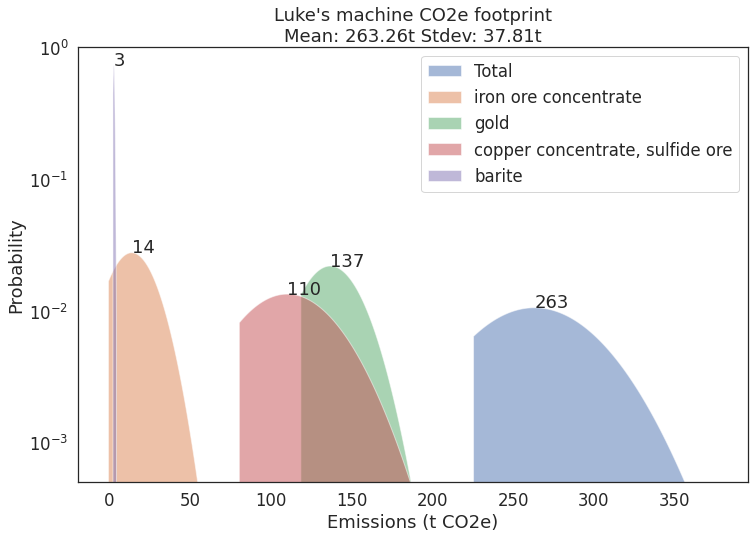

SankeyWidget(links=[{'source': 'barite', 'target': "Luke's machine", 'value': 2.6362512281179264, 'type': 0}, …

In [9]:
# @title Output footprint distributions for chosen product composition
emission_dist = get_footprint_dist(list(components_wg.value),list(map(lambda i: i.value, quantity_wg.children)),production,
                       provenance=list(map(lambda i: list(i.value), provenance_wg.children)), product_name=product_name)

## Graph representation

In [10]:
# @title Initialise graph representation

import networkx as nx
from more_itertools import locate

def concat_lists(lists):
        return list(itertools.chain.from_iterable(lists))

def draw_graph(nodes,edges,edgeWeights,nodeType):
    graph = nx.Graph()
    edges = zip(edges[0], edges[1], edgeWeights)
    graph.add_weighted_edges_from(edges)
    graph.add_nodes_from(nodes)
    pos = nx.kamada_kawai_layout(graph)
    fig, ax = plt.subplots(1,1,figsize=[10,10])
    nx.draw_networkx(graph,pos, with_labels=False, node_size=30, width=0.1, node_color=nodeType)

def pd_to_adj_matrix(df:pd.DataFrame, columns:list, weights:list):
  adj, edgeWeights = np.zeros([2,0]), []
  for i, column in enumerate(columns):
      edgeDest = [list(locate(df[column], lambda x: x==i)) for i in df[column]]
      edgeOrig = concat_lists([list(np.ones(len(x)).astype(int)*i) for i, x in enumerate(edgeDest)])
      edgeDest = concat_lists(edgeDest)
      nonSelf = np.where([val!=edgeDest[i] for i, val in enumerate(edgeOrig)])[0]
      adj = np.concatenate((adj,np.array([np.take(edgeOrig,nonSelf), np.take(edgeDest,nonSelf)])),axis=-1)
      edgeWeights = edgeWeights + [weights[i]]*len(edgeDest)
  return adj.astype(int), edgeWeights

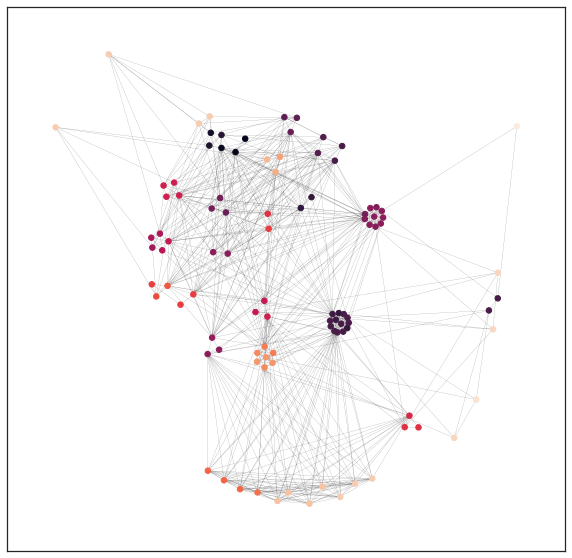

In [11]:
# @title Materials graph 
production.reset_index(drop=True, inplace=True)
edges, edgeWeights = pd_to_adj_matrix(production[:100], ['name','location'],[1,10])
draw_graph(production[:100].index, edges, edgeWeights, pd.factorize(production[:100].name)[0].astype(float))

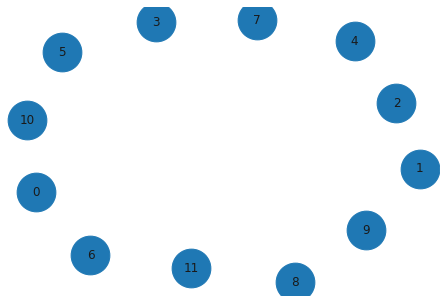

In [12]:
# @title Make demo graph
from sklearn.neighbors import kneighbors_graph
from data.netconf import netconf

# Choose your graph parameters - you can always come back once you understand what these mean
nodes = 12 # Total number of nodes
zeros = 2 # Nodes in class 0 
ones = 2 # Nodes in class 1
neighbours = 2 # Edges will be created to this number of nearest neighbours
cmap = 'RdYlGn' # No need to change unless you're fancying some groovy colours today

# Create a graph and add your nodes
G = nx.Graph() # Initialise the graph - nodes have got to go somewhere
G.add_nodes_from(range(nodes)) # Nodes going on
pos = nx.spring_layout(G) # Fix the positions of the nodes
nx.draw(G, pos=pos, node_size=1500, with_labels=True) # Let's have a look

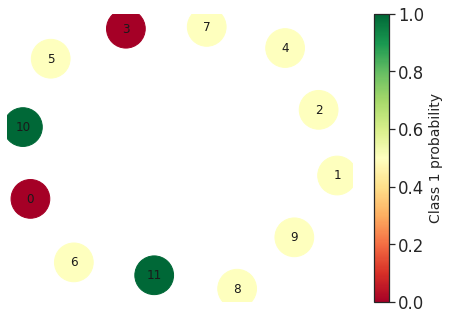

In [13]:
# @title Allocate classes
"""
Good start, now let's add our prior knowledge.

We'll randomly assign which nodes are to be in classes 0 and 1, with the rest 
being ignorant - i.e. 0.5 prior belief.
"""
priors = [1]*ones+[0]*zeros+[0.5]*(nodes-(ones+zeros))
np.random.shuffle(priors)

# Let's draw it again
nx.draw(G, pos=pos, node_size=1500, with_labels=True, node_color=priors, cmap=cmap)

# Don't worry about these, it's just adding a colorbar to look pretty
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
c = plt.colorbar(sm)
c.set_label('Class 1 probability', fontsize=14)

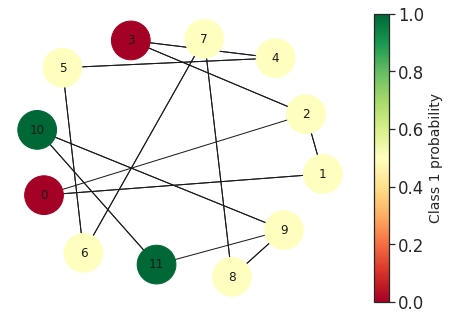

In [14]:
# @title Allocate edges
"""
We have our prior beliefs! Let's get some edges involved.

kneighbours_graph is a function which finds the nearest neighbours to each
node according to it's value. The values of our nodes are 0 to n (n being how
many nodes you chose) as displayed on each graph
"""
# Get edges
values = np.array(range(nodes)).reshape(-1,1) # Get our values in a vector
edges = kneighbors_graph(values,neighbours,mode='connectivity',include_self=False)

# Just a matrix re-shuffle to make the output usable, don't panic
edges = np.array(edges.nonzero()).reshape(2,-1).transpose() 

# Let's take another look
nx.draw(G, pos=pos, node_size=1500, with_labels=True, node_color=priors, cmap=cmap, edgelist=edges)
c = plt.colorbar(sm)
c.set_label('Class 1 probability', fontsize=14)

13  iterations


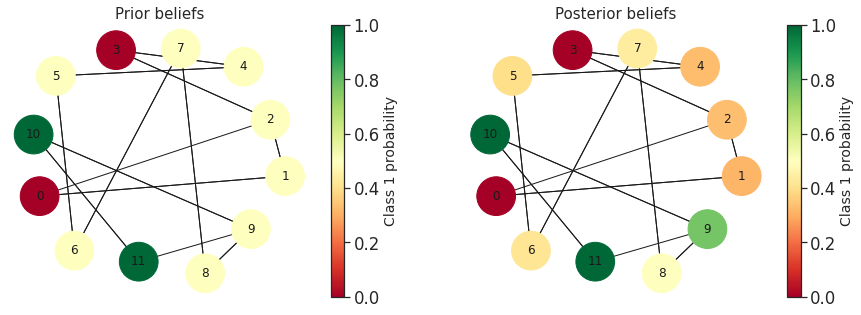

In [15]:
# @title Propagate beliefs
"""
Ok, here we are, let's fire up the beast!

Netconf is implemented in the netconf.py file, feel free to have a browse but there's 
not much need unless you're an equations enthusiast.
"""
priors = np.array(priors).reshape(-1,1) # Just a little matrix shimmy
posteriors, _ = netconf(edges,priors, verbose=False) # Here it goes! 

"""
Well, wasn't that exhilirating!
Ok, now we'll plot up the priors against the posteriors to see what actually went 
down.
"""
fig, axs = plt.subplots(1, 2, figsize=[15,5]) # Initialise a figure 

# Let's draw the prior beliefs
nx.draw(G, pos=pos, node_size=1500, with_labels=True, node_color=priors, cmap=cmap, edgelist=edges, ax=axs[0])
axs[0].set_title('Prior beliefs', fontsize=15)
c = plt.colorbar(sm, ax=axs[0])
c.set_label('Class 1 probability', fontsize=14)

# And now the posterior beliefs
nx.draw(G, pos=pos, node_size=1500, with_labels=True, node_color=posteriors, cmap=cmap, edgelist=edges, ax=axs[1])
axs[1].set_title('Posterior beliefs', fontsize=15)
c = plt.colorbar(sm, ax=axs[1])
c.set_label('Class 1 probability', fontsize=14)